In [57]:
from utils.image_treatment import preprocess_image
from wasserstein.texture_mixing_new import compute_texture_mixing
import matplotlib.pyplot as plt
import numpy as np
import pyrtools as pt
import matplotlib.pyplot as plt

In [59]:
#exemple où ça marche moins bien
image_path3 = 'data/161.gif'
image_path4 = 'data/Wall.jpg'
image3 = preprocess_image(image_path3, new_size = (256,256))
image4 = preprocess_image(image_path4, new_size = (256,256))
rho = [0.9, 0.1]
textures = [image3, image4]


In [61]:
synthesis_without_patch = compute_texture_mixing(textures, rho)
synthesis_with_patch = texture_mixing_high_dim(textures, rho, n_neighbor = 4, num_scales = 4, num_orientations = 4)

100%|██████████| 18/18 [04:35<00:00, 15.30s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'taking joint distribution')

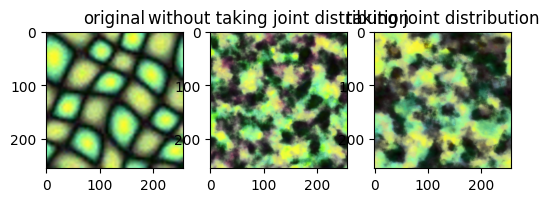

In [62]:
plt.figure(figsize=(6, 3))
plt.subplot(1,3,1)
plt.imshow(image3)
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(synthesis_without_patch)
plt.title('without taking joint distribution')
plt.subplot(1,3,3)
plt.imshow(synthesis_with_patch)
plt.title('taking joint distribution')


In [56]:
from skimage.util import view_as_blocks

def build_blocks(pyramid, block_shape = (4, 4, 3)):
    blocks = {}
    for key in pyramid.keys():
        # Diviser l'image en blocs
        blocks[key] = view_as_blocks(pyramid[key], block_shape=block_shape)
    return(blocks)

def block_projection(block_wn, block_barycenter):
    """
    Compute the projections of white noise pyramid coefficients on barycenter pyramid coefficients (see 13 in paper)

    Parameters:
    - pyramid_wn (dict): white noise pyramid coefficients
    - pyramid_barycenter (dict): barycenter pyramid coefficients

    Returns:
    - pyramid_wn (dict): projection of white noise pyramid coefficients on barycenter pyramid
    """
    for key in block_wn.keys():
        size = block_wn[key].shape[0]
        projection = compute_optimal_assignment(block_wn[key].reshape(-1, 4*4*3), block_barycenter[key].reshape(-1, 4*4*3)).reshape(size, size, 4, 4, 3)
        block_wn[key] = projection
    
    return(block_wn)

from tqdm import tqdm

def texture_mixing_high_dim(textures, rho, n_neighbor = 4, num_scales = 4, num_orientations = 4):
    size = textures[0].shape[0]
    noise = np.random.randn(size, size, 3)

    #calcul de Y
    Y = compute_optimal_transport_barycenter(noise.reshape(-1, 3), rho, [x.reshape(-1, 3) for x in textures], iterations=100).reshape(size, size, 3)

    #calculs de Y_l_j 
    pyramids = []
    for texture in textures:
        pyramids.append(build_pyramid(texture, num_scales=num_scales, num_orientations=num_orientations)) #returns a dico with pyramid for R,G,B
    #compute pyramid coefficients for white noise
    pyramid_wn = build_pyramid(noise, num_scales=num_scales, num_orientations=num_orientations)

    blocks = [build_blocks(x) for x in pyramids]
    block_wn = build_blocks(pyramid_wn)

    block_barycenter = {}
    for key in tqdm(block_wn.keys()):
        size = block_wn[key].shape[0]
        block_barycenter[key] = compute_optimal_transport_barycenter(block_wn[key].reshape(-1,n_neighbor*n_neighbor*3), rho, [x[key].reshape(-1,n_neighbor*n_neighbor*3) for x in blocks])
        block_barycenter[key] = block_barycenter[key].reshape(size, size, 1, n_neighbor, n_neighbor, 3)

    pyramid_barycenter = build_pyramid_barycenters(pyramid_wn, pyramids, rho, num_scales = num_scales, num_orientations = num_orientations)
    
    #(13), see article
    #noise = spectrum_constraint(noise, Y)
    pyramid_wn = build_pyramid(noise, num_scales=num_scales, num_orientations=num_orientations)
    c_lm = pyramid_projection(pyramid_wn, pyramid_barycenter)

    block_c_lm = build_blocks(c_lm)

    new_coeffs = block_projection(block_c_lm, block_barycenter)
    for key in new_coeffs.keys():
        size = new_coeffs[key].shape[0]
        new_coeffs[key] = new_coeffs[key].reshape(size*n_neighbor,size*n_neighbor,3)

    pyramid_barycenter_r = {}
    pyramid_barycenter_g = {}
    pyramid_barycenter_b = {}
    for key in pyramid_barycenter.keys(): #pour chaque coefficient (qui est pour l'instant en RGB)
        #il faut extraire les coefficients pour R, G et B
        pyramid_barycenter_r[key] = new_coeffs[key][:,:,0]
        pyramid_barycenter_g[key] = new_coeffs[key][:,:,1]
        pyramid_barycenter_b[key] = new_coeffs[key][:,:,2]

    #puis on reconstruit les images a partir de chaque pyramide R, G et B
    size = 256
    noise_for_pyr = np.random.randn(size, size)
    noisy_pyr = pt.pyramids.SteerablePyramidFreq(noise_for_pyr, height=4, order=4-1)

    noisy_pyr.pyr_coeffs = pyramid_barycenter_r
    reconstructed_pyr_r = noisy_pyr.recon_pyr()
    noisy_pyr.pyr_coeffs = pyramid_barycenter_g
    reconstructed_pyr_g = noisy_pyr.recon_pyr()
    noisy_pyr.pyr_coeffs = pyramid_barycenter_b
    reconstructed_pyr_b = noisy_pyr.recon_pyr()

    #f_tilde(k)
    reconstructed_pyr = np.stack((reconstructed_pyr_r, reconstructed_pyr_g, reconstructed_pyr_b), axis = -1)

    #f_k+1
    final_texture = compute_optimal_transport(reconstructed_pyr.reshape(-1,3), Y.reshape(-1, 3),iterations=50).reshape(size, size, 3)
    noise = final_texture

    return(final_texture.astype(int))

In [246]:
#exemple où ça marche moins bien
image_path3 = 'data/Red.jpg'
image_path4 = 'data/Wall.jpg'
image3 = preprocess_image(image_path3, new_size = (256,256))
image4 = preprocess_image(image_path4, new_size = (256,256))

textures = [image3, image4]
rho = [0.2, 0.5, 0.8]
final_texture_without_constraints = []
for r in rho:
    final_texture_without_constraints.append(texture_mixing_high_dim(textures, [1-r, r], num_scales = 4, num_orientations = 4))

100%|██████████| 18/18 [04:14<00:00, 14.13s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original $f^2$')

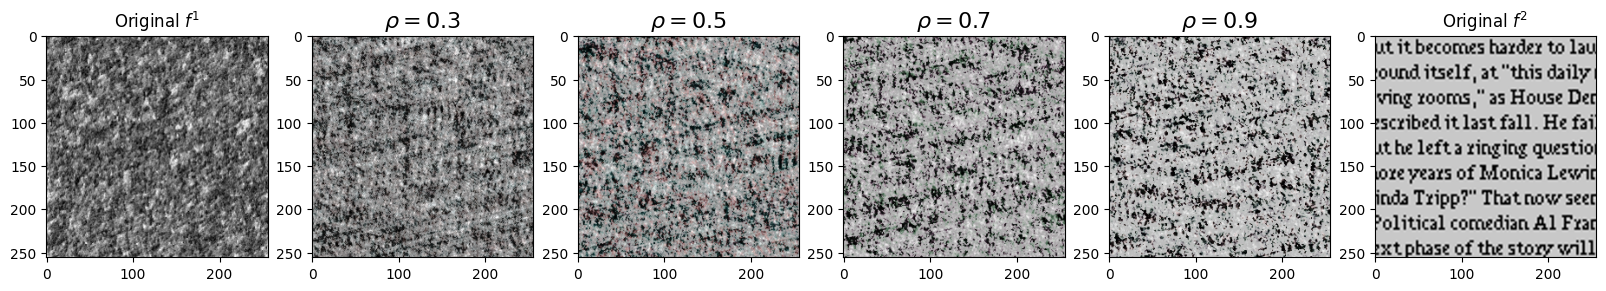

In [240]:
plt.figure(figsize=(20, 10))
plt.subplot(1,6,1)
plt.imshow(image3)
plt.title('Original $f^1$')
for i in range(len(final_texture_without_constraints)):
    plt.subplot(1,6,i+2)
    plt.imshow(final_texture_without_constraints[i].astype(int))
    plt.title(f'$\\rho = {rho[i]}$', fontsize=16)
plt.subplot(1,6,6)
plt.imshow(image4)
plt.title('Original $f^2$')